# K Nearest Neighbours by Scratch


## Part 1 - Implementing k-Nearest Neighbours (kNN) 

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

Each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.


In [1]:
class kNNClassifier:
    
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
    # your code goes here
    
        # Assign X and y as the training data in the class: 
        self.X_train = X
        self.Y_train = y
        
    def predict(self, X):
    # your code goes here
    
        # Assign X as the test data in the class:    
        self.X_test = X
        
        # Get the number of test samples:
        N = self.X_test.shape[0]
        
        # create a 3D array by expanding X_train N times on third axis - new shape is (N_train,2,N_test)
        X_3d = np.repeat(self.X_train[:, :, np.newaxis], N , axis=2)
        
        # compute distance for each point using broadcasting between X_train and X_test:
        dis = np.sqrt(np.sum((X_3d - self.X_test.T)**2, axis = 1)).T
        
        # We get 'dis' a matrix of distances with shape [N_test, N_train]
        
        # Use argsort to obtain the indecies of the closest neighbors, and slice from the closest to the k'th nearest niegbour. 
        neighbors = np.argsort(dis,axis=1)[:,:self.n_neighbors]
        
        # define a binary mask - when the sum of y's with the neighbors indecies is smaller than 0 we know that there is a 
        # majority of (-1) labeled points and vice verca.  
        mask = np.mean(self.Y_train[neighbors],axis = 1) < 0.5
        
        # create a new vector 'y_preds' of ones in the length of the number of test samples:
        y_preds = np.ones(self.X_test.shape[0])
        
        # Assign -1 to samples that have a majority of -1 labeled neighbors: 
        y_preds[mask] = 0
        
        return y_preds    

## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

The function `generate_data(m)` creates m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bmh")

def true_boundary_voting_pred(wealth, religiousness):
    return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed) 

    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
    y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
    y[y==0] = 1
    samples_to_flip = np.random.randint(0,m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]
    return X, y

def plot_labeled_data(X, y, no_titles=False):
    republicans = (y==1)
    democrats = (y==-1)
    plt.scatter(X[republicans,0], X[republicans,1], c='r')
    plt.scatter(X[democrats,0], X[democrats,1], c='b')
    if not no_titles:
        plt.xlabel('Wealth')
        plt.ylabel('Religiousness')
        plt.title('Red circles represent Republicans, Blues Democrats')

    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

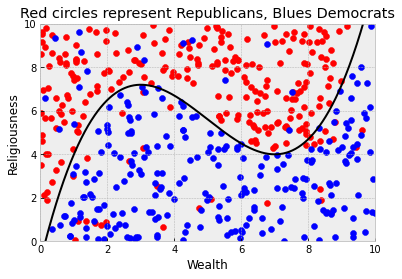

In [3]:
# Play a sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)


## Analysing the properties of kNN
Here we will generate multiple sample data sets of size 500 (using the given function above), and then we will plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).


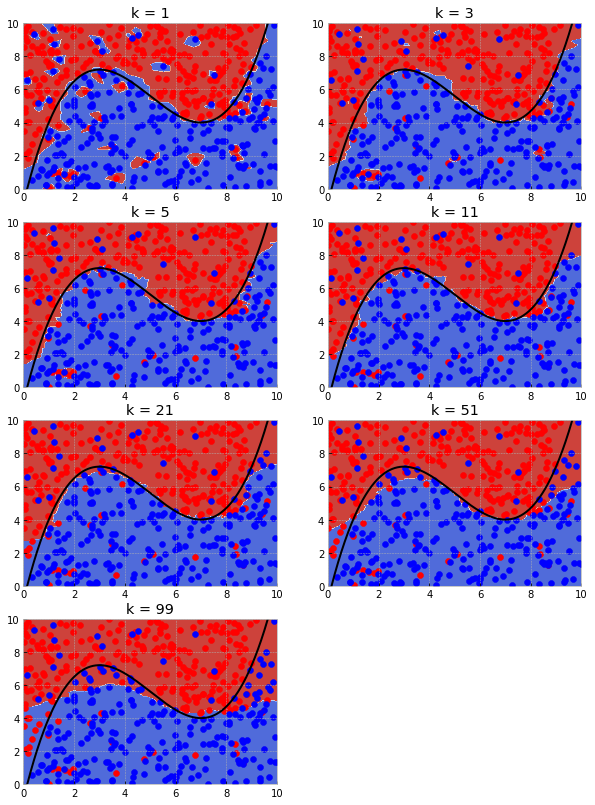

In [4]:
# Create a mesh of size [points x points] in the range of 0:10:
points = 200
XX,YY = np.meshgrid(np.linspace(0,10,points),np.linspace(0,10,points))
X_Mesh = np.array([XX.ravel(), YY.ravel()]).T

# for each value of the hyperparameter k we will plot a decision plane: 
k_s = [1, 3, 5, 11, 21, 51, 99]

# define number of columns for subplots:
num_cols = int(np.ceil(len(k_s)/2))

# define figure size:
plt.figure(figsize=(10,14))

# preprocess y's to be 1/0 instead of 1/-1
def process_y(y):
    Y = np.copy(y)
    Y[Y == -1] = 0
    return Y
Y = process_y(y)

# for each k, plot a decision plane:
for i, k in enumerate(k_s):
    knn = kNNClassifier(k)
    knn.fit(X, Y)
    mesh_points = knn.predict(X_Mesh)
    plt.subplot(num_cols,2,i+1)
    plt.title(f'k = {k}')
    plt.contourf(XX,YY,mesh_points.reshape(XX.shape),cmap ='coolwarm')
    plot_labeled_data(X, y, no_titles=True)

Discussion:  

As we can see from the plots above, the smaller the k is the more the classifier is overfitting the data, and as a result the decision plain will change according to the changes in the sample set. We can see that the overfitting phenomena creates small "islands" beyond the main decision plain.

When k is large the classifier is underfitting the data, and the decision plain would not be affected from minor changes in the sample set. We can also see that the behaviour of the decision plain is more smoother when the k is large enough.

We underfit the data when k is large - we can start observing it from k>=21, and we overfit the data when k  is small, in this case when k<5. 

Since we compute the distances of each point to all the other points, regardless of the number of k, O(n^2), the only complexity change depending on k is in the majority vote stage, which takes additional O(nk).   

## Finding the optimal k
Here, we sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Then we plot the train vs validation error for several k values, and we'll choose the best k. 


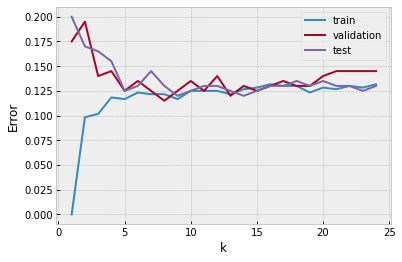

In [11]:
# code goes here

# import function for splitting data:
from sklearn.model_selection import train_test_split

# generate the data:
X, y = generate_data(m=1000)

# divide 20% to test:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

# divide 20% to validation and the rest 60% to train:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

# preprocess Y's:
Y_test = process_y(y_test)
Y_train = process_y(y_train)
Y_val = process_y(y_val)

# define hyperparameter k in range of 1 - 25:
k_s = np.arange(1,25)

# save train and validation error in the following lists: 
train_error = []
val_error = []
test_error = []

# a function that computes the accuracy error: 
def compute_error(y,preds):
    return int(np.sum(np.abs(y - preds)))/len(preds)

# fit the Knn classifier for all k's, and predict over the tain and validation sets: 
for k in k_s: 
    knn = kNNClassifier(k)
    knn.fit(X_train,Y_train)
    y_preds_train = knn.predict(X_train)
    y_preds_val = knn.predict(X_val)
    y_preds_test = knn.predict(X_test)
    train_error.append(compute_error(Y_train, y_preds_train))
    val_error.append(compute_error(Y_val, y_preds_val))
    test_error.append(compute_error(Y_test, y_preds_test))

# plot the training error vs. validation error with respect to 'k'
plt.plot(k_s, train_error, label = 'train')
plt.plot(k_s, val_error, label = 'validation')
plt.plot(k_s, test_error, label = 'test')
plt.legend()
plt.xlabel('k')
plt.ylabel('Error')
plt.show()

In [12]:
# chosen k is: 
k = 8

# fit knn with the chosen k:
knn = kNNClassifier(k)
knn.fit(X_train,y_train)

# predict for train, val and test:
y_preds_train = knn.predict(X_train)
y_preds_val = knn.predict(X_val)
y_preds_test = knn.predict(X_test)

# compute error for train, val and test: 
train_err = compute_error(Y_train, y_preds_train)
val_err = compute_error(Y_val, y_preds_val)
test_err = compute_error(Y_test, y_preds_test)

print(f'With a chosen k = {k}, the train error is: {train_err},  the validation error is: {val_err} and the test error is: {test_err}')

With a chosen k = 8, the train error is: 0.135,  the validation error is: 0.115 and the test error is: 0.165


 Since the classifier is very sensitive to the sampled data, and each run the generated data is different, there is no exact optimal k, but from many trial and error runs, we noticed that the optimal k ranges between 5 to 15. So, k that is smaller than 5 will overfit the data most of the times, and k larger than 15 will start underfit the data, and will give us more false positive/negative predictions within the training set. 
 
 
 If we optimize the model directly on the test, our optimal k assesment would certainly give us the best fit to the test set, but the model wouldnt be generalized to a different unseen data. The problem is that the model is very sensitive to the sample data, thus the optimal k derived from the validation set can be different in every run and can sometimes optimize the test set as well.
 
 Regardless, if we would have trained the model over the test set, the optimal k would be the one overfitting the data, which usually means k=1.

## Using cross validation
This time, we will put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 

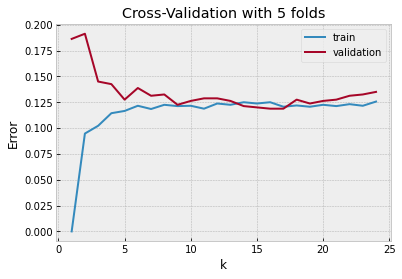

In [13]:
# Define number of folds:
n_folds = 5

# define fold size:
val_set_size = int(X_train_val.shape[0]/n_folds)

# save train and validation error in the following lists: 
train_error_cv5 = []
val_error_cv5 = []

# preprocess Y's:
Y_train_val = process_y(y_train_val)

# run algorithm over each k: 
for k in k_s:
    
    # initialize classifier: 
    knn = kNNClassifier(k)
    
    # initialize commulitive error for folds:
    tot_train_err = 0
    tot_val_err = 0
    
    # iterate over folds: 
    for fold in range(n_folds):
        
        # define mask for current fold:
        mask = np.zeros(X_train_val.shape[0],'bool')
        mask[fold*val_set_size : (fold+1)*val_set_size] = True

        # slice dataset using mask: 
        x_train_cv5, x_val_cv5 = X_train_val[~mask], X_train_val[mask]
        y_train_cv5, y_val_cv5 = Y_train_val[~mask], Y_train_val[mask]

        # fit knn: 
        knn.fit(x_train_cv5 ,y_train_cv5)

        # predict for train and val:
        y_preds_train_cv5 = knn.predict(x_train_cv5)
        y_preds_val_cv5 = knn.predict(x_val_cv5)

        # sum the errors over folds:
        tot_train_err += compute_error(y_train_cv5, y_preds_train_cv5)
        tot_val_err += compute_error(y_val_cv5, y_preds_val_cv5)
    
    # append average error for each k: 
    train_error_cv5.append(tot_train_err/5)
    val_error_cv5.append(tot_val_err/5)
    
# plot the training error vs. validation error with respect to 'k'
plt.style.use("bmh")
plt.plot(k_s, train_error_cv5, label = 'train')
plt.plot(k_s, val_error_cv5, label = 'validation')
plt.legend()
plt.xlabel('k')
plt.ylabel('Error')
plt.title('Cross-Validation with 5 folds')
plt.show() 

After a cross validation process we get a more generalized relationship between the train and the validation sets, since the graphes are obtained from averaging runs. We can therefore observe a more consistent behaviour of the two graphes. 
But, we initially ran the first model many times to understand the general behaviour of the classifier on the data, and we figured out that it is very sensitive to the data. From this we understood that the optimal k lies within a certain range, and we also saw that for the CV model the optimal k still lies in that range.  